In [ ]:
print("--- Step 1: Installing/Updating Libraries & Importing ---")
# !pip install -q --upgrade transformers datasets accelerate torch
# !pip install -q numpy pandas opencv-python scikit-learn scipy tensorflow Pillow tqdm kaggle seaborn matplotlib

import os
import glob
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Conv2D, MaxPooling2D,
                                     Flatten, Concatenate, Reshape, Multiply)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import welch
import torch
from transformers import SwinModel, AutoFeatureExtractor, pipeline
from transformers import AutoTokenizer
from IPython.display import display, Javascript, Image as IPImage
from google.colab import files
from google.colab.output import eval_js
from base64 import b64decode
import io
from PIL import Image as PILImage
import time
from tqdm.notebook import tqdm
import traceback
import random # For pairing data

print("Libraries installed/updated and imported.")

--- Step 1: Installing/Updating Libraries & Importing ---
Libraries installed/updated and imported.


In [ ]:
# Step 1.5: Configure Kaggle API
# ==============================================================================
print("\n--- Step 1.5: Configuring Kaggle API ---")
kaggle_path = "/root/.kaggle/kaggle.json"
COLAB_FER_PATH = "/content/datasets/fer2013"
COLAB_BONN_PATH = "/content/datasets/bonn_eeg" # Path for Bonn data

kaggle_setup_success = False
if not os.path.exists(kaggle_path):
    print("Please upload your kaggle.json file")
    try:
        uploaded = files.upload()
        if "kaggle.json" in uploaded:
            os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
            os.rename("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
            os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
            print("Kaggle API configured.")
            kaggle_setup_success = True
        else:
            print("ERROR: kaggle.json not found in uploaded files.")
    except Exception as e:
        print(f"An error occurred during Kaggle setup: {e}")
else:
    print("Kaggle API already configured.")
    kaggle_setup_success = True

if not kaggle_setup_success:
    raise RuntimeError("Kaggle API setup failed. Cannot proceed.")



--- Step 1.5: Configuring Kaggle API ---
Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Kaggle API configured.


In [ ]:
# Step 1.6: Download datasets from Kaggle (with Post-Download Reorganization)
# ==============================================================================
import time
import glob
import os
import shutil # Needed for file moving/copying

# Define Bonn categories if not already defined globally in Step 3
BONN_CATEGORIES = ['Z', 'O', 'N', 'F', 'S']

print("\n--- Step 1.6: Downloading Datasets ---")
if kaggle_setup_success:
    os.makedirs(COLAB_FER_PATH, exist_ok=True)
    os.makedirs(COLAB_BONN_PATH, exist_ok=True) # Ensure base Bonn dir exists

    # --- Download FER-2013 ---
    print("\nDownloading FER-2013 dataset...")
    fer_train_path_check = os.path.join(COLAB_FER_PATH, "train")
    if not os.path.exists(fer_train_path_check):
        print("Running Kaggle download command for FER-2013...")
        exit_code_fer = os.system(f"kaggle datasets download -d msambare/fer2013 -p {COLAB_FER_PATH} --unzip -q --force")
        if exit_code_fer != 0: print(f"ERROR: Kaggle command failed for FER-2013 (exit code {exit_code_fer}).")
        if not os.path.exists(fer_train_path_check): print("ERROR: FER-2013 download/extraction failed.")
        else: print("FER-2013 download successful.")
    else:
        print("FER-2013 dataset seems to exist already.")

    # --- Download and Organize Bonn EEG ---
    print("\nProcessing Bonn EEG dataset files...")
    needs_processing = True # Assume we need to check/process unless data is perfectly ready

    # Check if the final desired state already exists
    bonn_folders_exist = all(os.path.isdir(os.path.join(COLAB_BONN_PATH, f)) for f in BONN_CATEGORIES)
    sample_files_in_Z = glob.glob(os.path.join(COLAB_BONN_PATH, 'Z', '*.txt'))

    if bonn_folders_exist and sample_files_in_Z:
         print("Bonn EEG dataset (subfolders with files) seems correctly structured already.")
         needs_processing = False
    else:
         print("Bonn EEG structure check failed or incomplete. Will attempt download/reorganization.")
         needs_processing = True

    if needs_processing:
        # Attempt download first if needed (covers case where dir is empty)
        print("Running Kaggle download command for Bonn EEG...")
        # REMOVED -q (quiet flag) to see potential Kaggle errors
        kaggle_command_bonn = f"kaggle datasets download -d ashwanikumari/bonn-university-eeg -p {COLAB_BONN_PATH} --unzip --force"
        print(f"Executing: {kaggle_command_bonn}")
        exit_code_bonn = os.system(kaggle_command_bonn)
        print(f"Kaggle command exit code for Bonn EEG: {exit_code_bonn}")
        if exit_code_bonn != 0:
            print("ERROR: Kaggle download command failed. Skipping reorganization.")
        else:
            print("\nAttempting post-download file reorganization...")
            time.sleep(2) # Give FS time to sync

            target_path = COLAB_BONN_PATH

            # Reorganization Step 1: Handle nested folder
            try:
                contents = os.listdir(target_path)
                # Check if there's exactly one item and it's a directory (common Kaggle zip structure)
                if len(contents) == 1 and os.path.isdir(os.path.join(target_path, contents[0])):
                    # Check if the nested folder name clashes with a category name - unlikely but possible
                    if contents[0] not in BONN_CATEGORIES:
                         nested_folder_path = os.path.join(target_path, contents[0])
                         print(f"Found nested folder: {nested_folder_path}. Moving contents up...")
                         # Move items from nested folder to target_path
                         for item in os.listdir(nested_folder_path):
                             s = os.path.join(nested_folder_path, item)
                             d = os.path.join(target_path, item)
                             shutil.move(s, d)
                         # Remove the now-empty nested folder
                         os.rmdir(nested_folder_path)
                         print("Contents moved up and nested folder removed.")
                    else:
                         print(f"Warning: Found a directory '{contents[0]}' which matches a category name. Assuming it's correct, not treating as nested.")

                # Reorganization Step 2: Ensure category subfolders exist
                for cat in BONN_CATEGORIES:
                    cat_path = os.path.join(target_path, cat)
                    if not os.path.exists(cat_path):
                        os.makedirs(cat_path)
                        print(f"Created missing category folder: {cat_path}")

                # Reorganization Step 3: Move .txt files to appropriate subfolders
                txt_files_in_root = glob.glob(os.path.join(target_path, '*.txt'))
                print(f"Found {len(txt_files_in_root)} .txt files in the root directory to potentially move.")
                files_moved_count = 0
                if txt_files_in_root:
                    for txt_file_path in txt_files_in_root:
                        filename = os.path.basename(txt_file_path)
                        if filename and not filename.startswith('.'):  # Ensure filename is valid and not hidden
                            first_char = filename[0].upper()
                            if first_char in BONN_CATEGORIES:
                                dest_folder = os.path.join(target_path, first_char)
                                # Check if destination folder exists (it should after Step 2)
                                if os.path.exists(dest_folder):
                                     shutil.move(txt_file_path, os.path.join(dest_folder, filename))
                                     # print(f"Moved {filename} to {dest_folder}") # Optional: print each move
                                     files_moved_count += 1
                                else:
                                     print(f"Warning: Destination folder {dest_folder} not found for {filename}. Skipping move.") # Should not happen
                            else:
                                print(f"File {filename} does not start with a known category letter ({', '.join(BONN_CATEGORIES)}). Leaving in root.")
                    print(f"Finished moving files. Moved {files_moved_count} files into category subfolders.")
                else:
                    print("No .txt files found in the root directory requiring moving.")
                print("File reorganization process finished.")

            except Exception as e:
                print(f"ERROR during file reorganization: {e}")
                traceback.print_exc()


    # --- Final Dataset Checks ---
    print("\n--- Final Dataset Checks ---")
    if os.path.isdir(fer_train_path_check): print(f"OK: Found FER-2013 train directory: {fer_train_path_check}")
    else: print("ERROR: FER-2013 'train' directory not found.")

    # Final check for Bonn data presence *after potential reorganization*
    bonn_folders_ok = all(os.path.isdir(os.path.join(COLAB_BONN_PATH, f)) for f in BONN_CATEGORIES)
    bonn_files_in_Z_ok = glob.glob(os.path.join(COLAB_BONN_PATH, 'Z', '*.txt'))

    if bonn_folders_ok and bonn_files_in_Z_ok:
         print(f"OK: Found Bonn EEG subfolder structure and files within 'Z' in {COLAB_BONN_PATH}.")
         bonn_data_present = True
    elif not bonn_folders_ok:
         # If folders don't exist, but files ARE in root, it means reorganization failed, but data *might* be usable
         bonn_files_in_root = glob.glob(os.path.join(COLAB_BONN_PATH, '*.txt'))
         if bonn_files_in_root:
             print(f"WARNING: Bonn EEG subfolder structure NOT found, but {len(bonn_files_in_root)} .txt files ARE in root ({COLAB_BONN_PATH}). Reorganization might have failed. The loading step MAY still work if adapted.")
             bonn_data_present = True # Consider it present for loading attempt, but flag the issue
         else:
             print(f"ERROR: Bonn EEG data seems missing or incomplete. Neither subfolders nor root .txt files found in {COLAB_BONN_PATH}.")
             bonn_data_present = False
    elif bonn_folders_ok and not bonn_files_in_Z_ok:
         print(f"ERROR: Bonn EEG subfolders found, but no .txt files were found within the 'Z' folder in {COLAB_BONN_PATH}. Reorganization might have failed or data is incomplete.")
         bonn_data_present = False
    else: # Should not be reached if logic is sound
         print(f"ERROR: Unknown state for Bonn EEG data in {COLAB_BONN_PATH}.")
         bonn_data_present = False
else:
    print("\nSkipping dataset download due to Kaggle API setup failure.")
    bonn_data_present = False


--- Step 1.6: Downloading Datasets ---

Running Kaggle download command for FER-2013...
FER-2013 download successful.

Processing Bonn EEG dataset files...
Bonn EEG structure check failed or incomplete. Will attempt download/reorganization.
Running Kaggle download command for Bonn EEG...
Executing: kaggle datasets download -d ashwanikumari/bonn-university-eeg -p /content/datasets/bonn_eeg --unzip --force
Kaggle command exit code for Bonn EEG: 0

Attempting post-download file reorganization...
Found nested folder: /content/datasets/bonn_eeg/Bonn Univeristy Dataset. Moving contents up...
Contents moved up and nested folder removed.
Found 0 .txt files in the root directory to potentially move.
No .txt files found in the root directory requiring moving.
File reorganization process finished.

--- Final Dataset Checks ---
OK: Found FER-2013 train directory: /content/datasets/fer2013/train
OK: Found Bonn EEG subfolder structure and files within 'Z' in /content/datasets/bonn_eeg.


In [ ]:
# Step 1.7: Download Haar Cascade for Face Detection
# ==============================================================================
print("\n--- Step 1.7: Downloading Haar Cascade ---")
CASCADE_PATH = "haarcascade_frontalface_default.xml"
CASCADE_URL = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

if not os.path.exists(CASCADE_PATH):
    print(f"Downloading Haar Cascade from {CASCADE_URL}...")
    try:
        # Use wget for simplicity in Colab
        exit_code = os.system(f"wget -O {CASCADE_PATH} {CASCADE_URL}")
        if exit_code == 0 and os.path.exists(CASCADE_PATH):
            print("Haar Cascade downloaded successfully.")
        else:
            print(f"ERROR: Failed to download Haar Cascade (wget exit code: {exit_code}). Face detection in live mode will fail.")
    except Exception as e:
        print(f"ERROR downloading Haar Cascade: {e}")
else:
    print("Haar Cascade file already exists.")

# Load the cascade classifier globally or ensure it's loaded before prediction
try:
    face_cascade = cv2.CascadeClassifier(CASCADE_PATH)
    if face_cascade.empty():
        print(f"ERROR: Failed to load Haar Cascade from {CASCADE_PATH} even though file might exist.")
    else:
        print("Haar Cascade loaded successfully.")
except Exception as e:
    print(f"Error loading Haar Cascade: {e}")
    face_cascade = None # Mark as None if loading fails


--- Step 1.7: Downloading Haar Cascade ---
Haar Cascade downloaded successfully.
Haar Cascade loaded successfully.


In [ ]:
# Step 3: Define Constants and Configuration
# ==============================================================================
print("\n--- Step 3: Defining Constants ---")
# --- Data Parameters ---
VIDEO_TARGET_SIZE = (224, 224)
EEG_CHANNELS = 1 # Bonn data is single channel
EEG_SIGNAL_LENGTH = 4097 # Each Bonn file has 4097 data points
EEG_SAMPLE_RATE_HZ = 173.61 # Specific rate for Bonn dataset
NPERSEG_WELCH = 256 # Increased for better frequency resolution with longer signal, must be <= EEG_SIGNAL_LENGTH
FREQ_BANDS = { "Theta": (4, 8), "Alpha": (8, 13), "Beta": (13, 30), "Gamma": (30, 50)} # 4 bands
NUM_EEG_FEATURES = len(FREQ_BANDS) * EEG_CHANNELS # Now 4 * 1 = 4

# --- Model Parameters ---
SWIN_FEATURE_DIM = 768

# --- Unified Emotion Mapping ---
UNIFIED_EMOTION_MAP = {"Happy": 0, "Stressed": 1, "Anxious": 2, "Depressed": 3, "Normal": 4}
NUM_CLASSES = len(UNIFIED_EMOTION_MAP)
CLASS_LABELS = {v: k for k, v in UNIFIED_EMOTION_MAP.items()}

# --- FER Mapping ---
FER_LABEL_MAP_ORIGINAL = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
FER_TO_UNIFIED = {
    'angry': UNIFIED_EMOTION_MAP['Stressed'], 'disgust': UNIFIED_EMOTION_MAP['Depressed'],
    'fear': UNIFIED_EMOTION_MAP['Anxious'], 'happy': UNIFIED_EMOTION_MAP['Happy'],
    'neutral': UNIFIED_EMOTION_MAP['Normal'], 'sad': UNIFIED_EMOTION_MAP['Depressed'],
    'surprise': UNIFIED_EMOTION_MAP['Happy']
}
# --- Bonn Label Mapping (For reference/loading, not primary training target) ---
# Original Bonn Meaning: Z/O=Healthy, N/F=Epileptic-Interictal (tumor/focus), S=Epileptic-Ictal
BONN_CATEGORIES = ['Z', 'O', 'N', 'F', 'S'] # Define the order/folders if they exist

# --- Colab Capture Parameters ---
EEG_RECORD_DURATION_SEC = 5 # Placeholder duration (doesn't directly affect loading Bonn)

print("Constants defined (EEG adapted for Bonn).")



--- Step 3: Defining Constants ---
Constants defined (EEG adapted for Bonn).


In [ ]:
# Step 4: Load Pretrained Models
# ==============================================================================
print("\n--- Step 4: Loading Pretrained Models ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Using device: {device}")
swin_feature_extractor=None; swin_model=None; text_generator=None
try:
    swin_feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
    swin_model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224"); swin_model.to(device); swin_model.eval(); print("Swin base model loaded.")
except Exception as e: print(f"Error loading Swin model: {e}")
try:
    pipeline_device = 0 if torch.cuda.is_available() else -1
    text_generator = pipeline("text-generation", model="gpt2", device=pipeline_device); print("GPT-2 model loaded.")
except Exception as e: print(f"Error loading GPT-2 model: {e}")
if swin_model is None or text_generator is None: raise RuntimeError("Failed to load critical Hugging Face models.")
print("Pretrained models ready.")


--- Step 4: Loading Pretrained Models ---
Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Swin base model loaded.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


GPT-2 model loaded.
Pretrained models ready.


In [ ]:
# Step 5: Feature Extraction Functions (EEG adapted for Bonn)
# ==============================================================================
print("\n--- Step 5: Defining Feature Extraction Functions ---")

def extract_video_features(image_data):
    """Extracts features from a single image (numpy array) using SwinModel."""
    # (Same as previous version)
    if swin_model is None or swin_feature_extractor is None:
        print("Swin model/feature extractor not loaded!")
        return np.zeros(SWIN_FEATURE_DIM)
    try:
        if not isinstance(image_data, np.ndarray): return np.zeros(SWIN_FEATURE_DIM)
        if image_data.ndim == 2: frame_rgb = cv2.cvtColor(image_data, cv2.COLOR_GRAY2RGB)
        elif image_data.ndim == 3 and image_data.shape[-1] == 1: frame_rgb = cv2.cvtColor(image_data, cv2.COLOR_GRAY2RGB)
        elif image_data.ndim == 3 and image_data.shape[-1] == 4: frame_rgb = cv2.cvtColor(image_data, cv2.COLOR_RGBA2RGB)
        elif image_data.ndim == 3 and image_data.shape[-1] == 3: frame_rgb = image_data
        else: print(f"Unexpected image shape: {image_data.shape}"); return np.zeros(SWIN_FEATURE_DIM)
        if frame_rgb.shape[:2] != VIDEO_TARGET_SIZE: frame_resized = cv2.resize(frame_rgb, VIDEO_TARGET_SIZE, interpolation=cv2.INTER_AREA)
        else: frame_resized = frame_rgb
        image_pil = PILImage.fromarray(frame_resized)
        inputs = swin_feature_extractor(images=image_pil, return_tensors="pt").to(device)
        with torch.no_grad(): outputs = swin_model(**inputs); features = outputs.pooler_output
        return features.cpu().numpy().flatten()
    except Exception as e: print(f"!!! EXCEPTION in extract_video_features: {e}"); traceback.print_exc(); return np.zeros(SWIN_FEATURE_DIM)


def calculate_band_power_single_channel(eeg_signal, sfreq, bands, nperseg):
    """Calculates average power in specified frequency bands for a single EEG channel signal."""
    band_powers = []
    target_size = len(bands) # For single channel
    eeg_signal = eeg_signal.astype(float)

    if len(eeg_signal) < nperseg:
        # print(f"Warning: EEG signal length ({len(eeg_signal)}) < nperseg ({nperseg}). Returning zeros.")
        return np.zeros(target_size)
    if np.any(np.isnan(eeg_signal)) or np.any(np.isinf(eeg_signal)):
        # print(f"Warning: NaN/Inf found in EEG signal. Returning zeros.")
        return np.zeros(target_size)

    try:
        freqs, psd = welch(eeg_signal, fs=sfreq, nperseg=nperseg, nfft=max(nperseg, 512)) # Increased nfft slightly
        for band, (low_freq, high_freq) in bands.items():
            band_mask = (freqs >= low_freq) & (freqs < high_freq)
            # Ensure there are frequencies in the band before calculating mean
            avg_power = np.mean(psd[band_mask]) if np.sum(band_mask) > 0 else 0.0
            # Replace NaN results (e.g., if psd was zero) with 0.0
            band_powers.append(avg_power if not np.isnan(avg_power) else 0.0)
    except ValueError as ve:
        # print(f"ValueError during Welch: {ve}. Setting powers to 0.")
        band_powers = [0.0] * len(bands)
    except Exception as ex:
        # print(f"Exception during Welch: {ex}. Setting powers to 0.")
        band_powers = [0.0] * len(bands)

    # Ensure the output has the correct shape
    output_powers = np.array(band_powers)
    if output_powers.shape[0] != target_size:
         # print(f"Warning: Final band power shape {output_powers.shape} != target {target_size}. Returning zeros.")
         return np.zeros(target_size)
    return output_powers


def process_bonn_eeg_signal(eeg_signal):
    """Processes a raw 1D Bonn EEG signal into normalized band power features."""
    target_feature_size = NUM_EEG_FEATURES # Should be 4
    try:
        if not isinstance(eeg_signal, np.ndarray): return np.zeros(target_feature_size)
        if eeg_signal.ndim != 1 or len(eeg_signal) != EEG_SIGNAL_LENGTH:
            # print(f"EEG signal shape {eeg_signal.shape} is not ({EEG_SIGNAL_LENGTH},). Returning zeros.")
            return np.zeros(target_feature_size)

        # Calculate band powers for the single channel
        features = calculate_band_power_single_channel(
            eeg_signal,
            sfreq=EEG_SAMPLE_RATE_HZ,
            bands=FREQ_BANDS,
            nperseg=NPERSEG_WELCH
        )

        if features.shape[0] != target_feature_size:
            # print(f"Band power feature dimension mismatch ({features.shape[0]} vs {target_feature_size}). Returning zeros.")
            return np.zeros(target_feature_size)

        # Z-score normalization (across the 4 band power features)
        mean = np.mean(features)
        std = np.std(features)
        features_norm = (features - mean) / (std if std > 1e-6 else 1.0)

        if np.any(np.isnan(features_norm)):
            # print("NaNs found after EEG normalization. Returning zeros.")
            return np.zeros(target_feature_size)
        return features_norm

    except Exception as e:
        print(f"Error processing EEG signal: {e}")
        traceback.print_exc()
        return np.zeros(target_feature_size)

print("Feature extraction functions defined (EEG adapted for single-channel Bonn).")


--- Step 5: Defining Feature Extraction Functions ---
Feature extraction functions defined (EEG adapted for single-channel Bonn).


In [ ]:
# Step 6: Data Loading and Preprocessing Function (FER + Bonn EEG Pairing)
# ==============================================================================

def load_and_preprocess_data(fer_base_path, bonn_base_path, fer_splits=['train'], max_fer_samples_per_class=None, max_bonn_signals_per_cat=None):
    """ Loads FER images, Bonn EEG signals, pairs them randomly, extracts features, and prepares for training.
        Trains on FER sentiment labels, using EEG as context.
    """
    print("--- Starting Data Loading (FER + Bonn EEG Pairing) ---")
    fer_images = []
    fer_labels_unified = []
    bonn_signals = []
    # bonn_labels_original = [] # Optionally store original Bonn labels

    loaded_count_fer = 0
    skipped_fer = 0
    loaded_count_bonn = 0

    # --- 1. Load FER-2013 Data ---
    if fer_base_path and os.path.isdir(fer_base_path):
        print(f"Processing FER-2013 from: {fer_base_path}")
        for split in fer_splits:
            split_path = os.path.join(fer_base_path, split)
            if not os.path.isdir(split_path): continue
            print(f"\nLoading FER '{split}' split...")
            available_emotions = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])

            for emotion_str_orig in available_emotions:
                if emotion_str_orig not in FER_TO_UNIFIED: continue
                unified_label = FER_TO_UNIFIED[emotion_str_orig]
                emotion_dir = os.path.join(split_path, emotion_str_orig)
                image_files = glob.glob(os.path.join(emotion_dir, '*.jpg')) + glob.glob(os.path.join(emotion_dir, '*.png'))
                if not image_files: continue

                print(f"  Loading {emotion_str_orig} -> {CLASS_LABELS.get(unified_label, '???')}...")
                count_per_class = 0
                for img_path in tqdm(image_files, desc=f"  FER {emotion_str_orig}", leave=False):
                    if max_fer_samples_per_class and count_per_class >= max_fer_samples_per_class: break
                    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if image is None: skipped_fer += 1; continue
                    fer_images.append(image)
                    fer_labels_unified.append(unified_label)
                    count_per_class += 1
                    loaded_count_fer += 1
                if max_fer_samples_per_class: print(f"   Loaded {count_per_class} samples.")
            if max_fer_samples_per_class: print(f"  (Limited to {max_fer_samples_per_class}/class for FER '{split}' split)")
    else:
        print(f"Warning: FER base path '{fer_base_path}' not valid. Cannot load FER data.")
        return None

    if not fer_images:
        print("ERROR: No FER images were loaded.")
        return None

    # --- 2. Load Bonn EEG Data ---
    if bonn_base_path and os.path.isdir(bonn_base_path):
        print(f"\nProcessing Bonn EEG from: {bonn_base_path}")
        # Check structure: are files in root or subfolders Z, O, N, F, S?
        has_subfolders = any(os.path.isdir(os.path.join(bonn_base_path, f)) for f in BONN_CATEGORIES)

        search_paths = []
        if has_subfolders:
            print(" Bonn data seems organized in subfolders (Z, O, N, F, S).")
            for category in BONN_CATEGORIES:
                cat_path = os.path.join(bonn_base_path, category)
                if os.path.isdir(cat_path):
                    search_paths.append(cat_path)
                else:
                    print(f" Warning: Bonn category folder '{category}' not found.")
        else:
            print(" Bonn data seems to be directly in the root folder.")
            search_paths.append(bonn_base_path) # Search directly in the base path

        if not search_paths:
             print("ERROR: Could not determine Bonn EEG file locations. No valid search paths.")
             return None

        for search_path in search_paths:
             print(f" Loading EEG signals from: {search_path}")
             files_in_path = glob.glob(os.path.join(search_path, '*.txt'))
             category_label = os.path.basename(search_path) if has_subfolders else 'Root' # Get category if applicable
             count_per_cat = 0

             for fname in tqdm(files_in_path, desc=f"  Bonn {category_label}", leave=False):
                 if max_bonn_signals_per_cat and count_per_cat >= max_bonn_signals_per_cat: break
                 try:
                     signal = np.loadtxt(fname)
                     if signal.shape == (EEG_SIGNAL_LENGTH,): # Check if it's the expected 1D array
                         bonn_signals.append(signal)
                         # bonn_labels_original.append(category_label) # Optional
                         count_per_cat += 1
                         loaded_count_bonn += 1
                     # else: print(f" Skipped {fname}, unexpected shape {signal.shape}")
                 except Exception as e:
                     print(f" Error loading {fname}: {e}")
             if max_bonn_signals_per_cat: print(f"  Loaded {count_per_cat} signals from {category_label}.")

    else:
        print(f"Warning: Bonn EEG base path '{bonn_base_path}' not valid. Cannot load EEG data.")
        return None

    if not bonn_signals:
        print("ERROR: No Bonn EEG signals were loaded.")
        return None

    print(f"\nLoaded {loaded_count_fer} FER images and {loaded_count_bonn} Bonn EEG signals.")
    print(f"(Skipped FER: {skipped_fer})")

    # --- 3. Feature Extraction and Random Pairing ---
    print("\nExtracting features and creating random pairs...")
    all_video_features = []
    all_eeg_features = []
    all_paired_labels = [] # These will be the FER labels

    for i in tqdm(range(len(fer_images)), desc="Pairing & Feature Extraction"):
        # Extract video feature
        video_feat = extract_video_features(fer_images[i])
        if np.all(video_feat == 0): # Skip if video extraction failed
            skipped_fer += 1 # Count skips here as well
            continue

        # Randomly select a Bonn EEG signal
        random_eeg_signal = random.choice(bonn_signals)

        # Extract EEG feature
        eeg_feat = process_bonn_eeg_signal(random_eeg_signal)
        if np.all(eeg_feat == 0): # Skip if EEG processing failed (less likely with random)
             # print(f"Warning: EEG feature extraction failed for a random signal sample. Skipping pair {i}.")
             continue # Or handle differently, maybe try another random signal?

        # Append the features and the corresponding FER label
        all_video_features.append(video_feat)
        all_eeg_features.append(eeg_feat)
        all_paired_labels.append(fer_labels_unified[i]) # Use the FER label

    # Clear large intermediate lists
    del fer_images, fer_labels_unified, bonn_signals

    if not all_paired_labels:
        print("ERROR: No valid pairs created after feature extraction.")
        return None

    print(f"\nCreated {len(all_paired_labels)} valid pairs.")
    print(f"(Total skipped FER images including extraction failures: {skipped_fer})")


    # --- 4. Convert to Numpy and Split ---
    try:
        X_vid = np.array(all_video_features, dtype=np.float32)
        X_eeg = np.array(all_eeg_features, dtype=np.float32)
        y = np.array(all_paired_labels) # FER sentiment labels
    except Exception as e:
         print(f"Error converting final data to NumPy arrays: {e}")
         return None

    print("\nFinal Paired Shapes Before Split:")
    print("  Video Features:", X_vid.shape)
    print("  EEG Features:", X_eeg.shape) # Should be (N, 4)
    print("  Labels (Sentiment):", y.shape)

    if X_eeg.shape[1] != NUM_EEG_FEATURES:
        print(f"ERROR: Final EEG feature dimension is {X_eeg.shape[1]}, expected {NUM_EEG_FEATURES}.")
        return None

    unique_labels, counts = np.unique(y, return_counts=True)
    print("\nSentiment Label Distribution in Paired Data:")
    for label_idx, count in zip(unique_labels, counts):
         print(f"  Label {label_idx} ({CLASS_LABELS.get(label_idx, 'Unknown')}): {count}")

    if len(y) < 5:
        print("ERROR: Not enough paired samples for split.")
        return None

    stratify_possible = len(unique_labels) > 1 and all(c >= 2 for c in counts)
    print(f"\nSplitting paired data 80/20 {'with' if stratify_possible else 'without'} stratification (based on sentiment labels)...")

    try:
         indices = np.arange(y.shape[0])
         stratify_opt = y if stratify_possible else None
         train_indices, val_indices, y_train_split, y_val_split = train_test_split(
             indices, y, test_size=0.2, random_state=42, stratify=stratify_opt
         )
         X_train_vid, X_val_vid = X_vid[train_indices], X_vid[val_indices]
         X_train_eeg, X_val_eeg = X_eeg[train_indices], X_eeg[val_indices]
         y_train_cat = to_categorical(y_train_split, num_classes=NUM_CLASSES)
         y_val_cat = to_categorical(y_val_split, num_classes=NUM_CLASSES)

         print(f"\nSplit complete. Train samples: {len(y_train_cat)}, Val samples: {len(y_val_cat)}")
         print("--- Data Loading & Pairing Finished ---")
         return (X_train_vid, X_train_eeg), y_train_cat, \
                (X_val_vid, X_val_eeg), y_val_cat
    except Exception as e:
        print(f"Error during final split/conversion: {e}")
        traceback.print_exc()
        return None

print("Data loading function updated (FER + Bonn EEG pairing).")


Data loading function updated (FER + Bonn EEG pairing).


In [ ]:
# Step 6.5: Execute Data Loading
# ==============================================================================
print("\n--- Step 6.5: Executing Data Loading (FER + Bonn) ---")
# Limits can be useful for debugging/faster runs
MAX_FER_SAMPLES = None # Load all FER per class
MAX_BONN_SAMPLES = 100 # Load max 100 signals per Bonn category (Z,O,N,F,S) to keep it manageable

loaded_data = load_and_preprocess_data(
    COLAB_FER_PATH,
    COLAB_BONN_PATH,
    fer_splits=['train', 'test'], # Load from both FER splits if needed
    max_fer_samples_per_class=MAX_FER_SAMPLES,
    max_bonn_signals_per_cat=MAX_BONN_SAMPLES
)

data_loaded_successfully = False
vid_input_dim, eeg_input_dim = None, None

if loaded_data:
    (X_train_vid, X_train_eeg), y_train, (X_val_vid, X_val_eeg), y_val = loaded_data
    if X_train_vid.size > 0 and y_train.size > 0:
        print("\nData Shapes Loaded Successfully:")
        print(f"  Train: Vid {X_train_vid.shape}, EEG {X_train_eeg.shape}, y {y_train.shape}")
        print(f"  Val:   Vid {X_val_vid.shape}, EEG {X_val_eeg.shape}, y {y_val.shape}")
        vid_input_dim=X_train_vid.shape[1]
        eeg_input_dim=X_train_eeg.shape[1]
        print(f"Model Input Dims Set: Vid={vid_input_dim}, EEG={eeg_input_dim}")
        if eeg_input_dim != NUM_EEG_FEATURES: print(f"!! WARNING: EEG Dim Mismatch ({eeg_input_dim} vs {NUM_EEG_FEATURES}) !!")
        data_loaded_successfully = True
    else: print("\nWARN: Data loading finished, but zero samples available.")
else: print("\nERR: Data loading function failed.")

if not data_loaded_successfully:
    print("Using Fallback Dims for model build check.")
    vid_input_dim=SWIN_FEATURE_DIM
    eeg_input_dim=NUM_EEG_FEATURES


--- Step 6.5: Executing Data Loading (FER + Bonn) ---
--- Starting Data Loading (FER + Bonn EEG Pairing) ---
Processing FER-2013 from: /content/datasets/fer2013

Loading FER 'train' split...
  Loading angry -> Stressed...


  FER angry:   0%|          | 0/3995 [00:00<?, ?it/s]

  Loading disgust -> Depressed...


  FER disgust:   0%|          | 0/436 [00:00<?, ?it/s]

  Loading fear -> Anxious...


  FER fear:   0%|          | 0/4097 [00:00<?, ?it/s]

  Loading happy -> Happy...


  FER happy:   0%|          | 0/7215 [00:00<?, ?it/s]

  Loading neutral -> Normal...


  FER neutral:   0%|          | 0/4965 [00:00<?, ?it/s]

  Loading sad -> Depressed...


  FER sad:   0%|          | 0/4830 [00:00<?, ?it/s]

  Loading surprise -> Happy...


  FER surprise:   0%|          | 0/3171 [00:00<?, ?it/s]


Loading FER 'test' split...
  Loading angry -> Stressed...


  FER angry:   0%|          | 0/958 [00:00<?, ?it/s]

  Loading disgust -> Depressed...


  FER disgust:   0%|          | 0/111 [00:00<?, ?it/s]

  Loading fear -> Anxious...


  FER fear:   0%|          | 0/1024 [00:00<?, ?it/s]

  Loading happy -> Happy...


  FER happy:   0%|          | 0/1774 [00:00<?, ?it/s]

  Loading neutral -> Normal...


  FER neutral:   0%|          | 0/1233 [00:00<?, ?it/s]

  Loading sad -> Depressed...


  FER sad:   0%|          | 0/1247 [00:00<?, ?it/s]

  Loading surprise -> Happy...


  FER surprise:   0%|          | 0/831 [00:00<?, ?it/s]


Processing Bonn EEG from: /content/datasets/bonn_eeg
 Bonn data seems organized in subfolders (Z, O, N, F, S).
 Loading EEG signals from: /content/datasets/bonn_eeg/Z


  Bonn Z:   0%|          | 0/100 [00:00<?, ?it/s]

  Loaded 100 signals from Z.
 Loading EEG signals from: /content/datasets/bonn_eeg/O


  Bonn O:   0%|          | 0/100 [00:00<?, ?it/s]

  Loaded 100 signals from O.
 Loading EEG signals from: /content/datasets/bonn_eeg/N


  Bonn N: 0it [00:00, ?it/s]

  Loaded 0 signals from N.
 Loading EEG signals from: /content/datasets/bonn_eeg/F


  Bonn F:   0%|          | 0/100 [00:00<?, ?it/s]

  Loaded 100 signals from F.
 Loading EEG signals from: /content/datasets/bonn_eeg/S


  Bonn S:   0%|          | 0/100 [00:00<?, ?it/s]

  Loaded 100 signals from S.

Loaded 35887 FER images and 400 Bonn EEG signals.
(Skipped FER: 0)

Extracting features and creating random pairs...


Pairing & Feature Extraction:   0%|          | 0/35887 [00:00<?, ?it/s]


Created 35887 valid pairs.
(Total skipped FER images including extraction failures: 0)

Final Paired Shapes Before Split:
  Video Features: (35887, 768)
  EEG Features: (35887, 4)
  Labels (Sentiment): (35887,)

Sentiment Label Distribution in Paired Data:
  Label 0 (Happy): 12991
  Label 1 (Stressed): 4953
  Label 2 (Anxious): 5121
  Label 3 (Depressed): 6624
  Label 4 (Normal): 6198

Splitting paired data 80/20 with stratification (based on sentiment labels)...

Split complete. Train samples: 28709, Val samples: 7178
--- Data Loading & Pairing Finished ---

Data Shapes Loaded Successfully:
  Train: Vid (28709, 768), EEG (28709, 4), y (28709, 5)
  Val:   Vid (7178, 768), EEG (7178, 4), y (7178, 5)
Model Input Dims Set: Vid=768, EEG=4


In [ ]:
# Step 7: Multimodal Model Architecture Definition (Video + EEG Only)
# ==============================================================================
print("\n--- Step 7: Defining Model Architecture (Video + EEG) ---")
def build_multimodal_model(video_dim, eeg_dim, num_classes=NUM_CLASSES):
    """Builds the 2-input attention-based multimodal fusion model (Video + EEG)."""
    if not all([video_dim, eeg_dim]): raise ValueError("Missing input dimensions.")

    vid_in = Input(shape=(video_dim,), name="video_input")
    eeg_in = Input(shape=(eeg_dim,), name="eeg_input") # Expecting NUM_EEG_FEATURES (e.g., 4)

    vid_d = Dense(128, activation='relu', name="vid_dense")(vid_in)
    vid_o = Dropout(0.3, name="vid_drop")(vid_d)

    # EEG Branch suitable for low-dim features
    eeg_d1 = Dense(32, activation='relu', name="eeg_dense1")(eeg_in)
    eeg_d2 = Dense(128, activation='relu', name="eeg_dense2")(eeg_d1)
    eeg_o = Dropout(0.3, name="eeg_drop")(eeg_d2)

    cat = Concatenate(name="concat")([vid_o, eeg_o])
    att_ctx = Dense(256, activation='tanh', name="att_ctx")(cat)
    att_w = Dense(2, activation='softmax', name="attention_weights")(att_ctx)
    att_r = Reshape((1, 2), name="att_resh")(att_w)

    vr = Reshape((128, 1), name="vid_r")(vid_o)
    er = Reshape((128, 1), name="eeg_r")(eeg_o)

    br = Concatenate(axis=-1, name="cat_r")([vr, er])
    wf = Multiply(name="apply_att")([br, att_r])
    fused = Flatten(name="flat_w")(wf)

    fc1 = Dense(128, activation='relu', name="fc1")(fused)
    dr1 = Dropout(0.5, name="drop1")(fc1)
    out_emotion = Dense(num_classes, activation='softmax', name="output_emotion")(dr1)

    model = Model(inputs=[vid_in, eeg_in], outputs=[out_emotion, att_w])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=['categorical_crossentropy', None],
                  metrics=[['accuracy'], None],
                  loss_weights=[1.0, 0.0])
    return model
print("Model definition function defined.")



--- Step 7: Defining Model Architecture (Video + EEG) ---
Model definition function defined.


In [ ]:
# Step 7.5: Build the Model Instance
# ==============================================================================
print("\n--- Step 7.5: Building Model Instance ---")
model = None
model_built_flag = False
if vid_input_dim and eeg_input_dim:
     try:
         model = build_multimodal_model(vid_input_dim, eeg_input_dim, num_classes=NUM_CLASSES)
         model.summary(line_length=100)
         print("Model built successfully.")
         model_built_flag = True
     except Exception as e: print(f"ERROR building model: {e}"); traceback.print_exc(); model_built_flag = False
else: print(f"ERROR: Cannot build model - Input dimensions missing/invalid (Vid: {vid_input_dim}, EEG: {eeg_input_dim})."); model_built_flag = False


--- Step 7.5: Building Model Instance ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ eeg_input (InputLayer)      │ (None, 4)               │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ video_input (InputLayer)    │ (None, 768)             │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ eeg_dense1 (Dense)          │ (None, 32)              │            160 │ eeg_input[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ vid_dense (Dense)           │ (None, 128)             │         98,432 │ video_input[0][0]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ eeg_dense2 (Dense)          │ (None, 128)             │          4,224 │ eeg_dense1[0][0]        │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ vid_drop (Dropout)          │ (None, 128)             │              0 │ vid_dense[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ eeg_drop (Dropout)          │ (None, 128)             │              0 │ eeg_dense2[0][0]        │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ concat (Concatenate)        │ (None, 256)             │              0 │ vid_drop[0][0],         │
│                             │                         │                │ eeg_drop[0][0]          │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ att_ctx (Dense)             │ (None, 256)             │         65,792 │ concat[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ vid_r (Reshape)             │ (None, 128, 1)          │              0 │ vid_drop[0][0]          │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ eeg_r (Reshape)             │ (None, 128, 1)          │              0 │ eeg_drop[0][0]          │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ attention_weights (Dense)   │ (None, 2)               │            514 │ att_ctx[0][0]           │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cat_r (Concatenate)         │ (None, 128, 2)          │              0 │ vid_r[0][0],            │
│                             │                         │                │ eeg_r[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ att_resh (Reshape)          │ (None, 1, 2)            │              0 │ attention_weights[0][0] │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ apply_att (Multiply)        │ (None, 128, 2)          │              0 │ cat_r[0][0],            │
│                             │                         │                │ att_resh[0][0]          │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ flat_w (Flatten)            │ (None, 256)             │              0 │ apply_att[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ fc1 (Dense)                 │ (None, 128)             │         32,896 │ flat_w[0][0]            │
├─────────────────────────────┼─────────────────────────┼────

 Total params: 202,663 (791.65 KB)

 Trainable params: 202,663 (791.65 KB)

 Non-trainable params: 0 (0.00 B)

Model built successfully.


In [ ]:
# Step 8: Model Training
# ==============================================================================
print("\n--- Step 8: Training Model ---")

# CORRECTED FILENAME EXTENSION for weights-only saving
MODEL_WEIGHTS_FILE = "multimodal_FER_BonnEEG_best.weights.h5" # Renamed for Keras compliance

history = None
if model_built_flag and data_loaded_successfully:
    print("Starting Model Training...")
    mc = tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_WEIGHTS_FILE,       # Use the CORRECTED filename
        save_weights_only=True,
        monitor='val_output_emotion_accuracy', # Monitor the accuracy of the main output
        mode='max',
        save_best_only=True,
        verbose=1
    )
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_output_emotion_accuracy', # Monitor the accuracy of the main output
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1,
        start_from_epoch=5 # Avoid stopping too early
    )
    EPOCHS=30; BATCH_SIZE=32

    train_in = [X_train_vid, X_train_eeg]
    train_out = {'output_emotion': y_train}
    val_in = [X_val_vid, X_val_eeg]
    val_out = {'output_emotion': y_val}

    history = model.fit(
        train_in, train_out, validation_data=(val_in, val_out),
        epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[mc, es]
    )
    print("\n--- Model Training Finished ---")
    if os.path.exists(MODEL_WEIGHTS_FILE): print(f"Best weights saved to {MODEL_WEIGHTS_FILE}.")
elif model_built_flag: print("Skipping Training (Data not loaded successfully).")
else: print("Skipping Training (Model not built).")


--- Step 8: Training Model ---
Starting Model Training...
Epoch 1/30
896/898 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5313 - output_emotion_accuracy: 0.3363
Epoch 1: val_output_emotion_accuracy improved from -inf to 0.41530, saving model to multimodal_FER_BonnEEG_best.weights.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 1.5312 - output_emotion_accuracy: 0.3364 - val_loss: 1.4405 - val_output_emotion_accuracy: 0.4153
Epoch 2/30
895/898 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4441 - output_emotion_accuracy: 0.4021
Epoch 2: val_output_emotion_accuracy improved from 0.41530 to 0.42937, saving model to multimodal_FER_BonnEEG_best.weights.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1.4440 - output_emotion_accuracy: 0.4021 - val_loss: 1.3856 - val_output_emotion_accuracy: 0.4294
Epoch 3/30
893/898 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4056 - output_emotion_accuracy: 0.4250
Epoch 3: val_output_emotion_accuracy improved from 0.42937 to 0.44163, saving model to multim


--- Step 8.5: Evaluating Model ---
Evaluating on validation set...

Validation Loss (Emotion Output): 1.2335
Validation Accuracy (Emotion Output): 50.79%

Generating classification report & confusion matrix...
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

       Happy       0.59      0.79      0.68      2598
    Stressed       0.44      0.30      0.36       991
     Anxious       0.41      0.18      0.25      1024
   Depressed       0.41      0.42      0.41      1325
      Normal       0.46      0.44      0.45      1240

    accuracy                           0.51      7178
   macro avg       0.46      0.43      0.43      7178
weighted avg       0.49      0.51      0.48      7178


Confusion Matrix:
[[2056  109   78  162  193]
 [ 294  297   56  219  125]
 [ 402   93  186  242  101]
 [ 334  129   82  556  224]
 [ 403   50   51  185  551]]


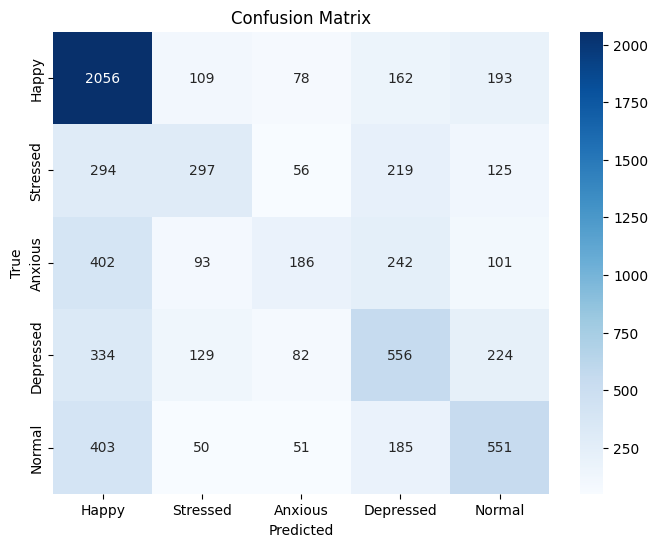


Average Attention Weights -> Video: 93.7% | EEG: 6.3%

--- Model Evaluation Finished ---


In [ ]:
# Step 8.5: Model Evaluation (Corrected Indexing)
# ==============================================================================
print("\n--- Step 8.5: Evaluating Model ---")
# Ensure necessary variables like 'model_built_flag', 'data_loaded_successfully', etc. exist from previous steps
if 'model' not in globals(): model = None # Define model as None if it doesn't exist
if 'data_loaded_successfully' not in globals(): data_loaded_successfully = False
if 'X_val_vid' not in globals(): X_val_vid = None
if 'y_val' not in globals(): y_val = None
# Add similar checks or ensure execution order if running cells independently

if model is not None and model_built_flag and data_loaded_successfully and X_val_vid is not None and X_val_vid.size > 0:
    print("Evaluating on validation set...")
    val_inputs = [X_val_vid, X_val_eeg] # Video and EEG inputs
    val_out_cat = {'output_emotion': y_val} # Target only for emotion output
    val_true_lbls = np.argmax(y_val, axis=1) # Ground truth labels (indices)

    try:
        # Ensure weights are loaded if training didn't run but file exists
        # Check if history object exists and indicates training occurred
        training_occurred = 'history' in globals() and history is not None and hasattr(history, 'history') and history.history
        if not training_occurred and os.path.exists(MODEL_WEIGHTS_FILE):
             try:
                 print(f"Loading best weights from {MODEL_WEIGHTS_FILE} for evaluation...")
                 model.load_weights(MODEL_WEIGHTS_FILE)
             except Exception as load_e:
                 print(f"Warning: Failed to load weights from {MODEL_WEIGHTS_FILE}: {load_e}")

        # When evaluating a model with multiple outputs & losses/metrics specified as done,
        # the return list structure might be simplified if only one output has effective metrics/loss.
        eval_results = model.evaluate(val_inputs, val_out_cat, batch_size=BATCH_SIZE, verbose=0)

        # --- CORRECTED INDEXING ---
        # Assume return is [loss, accuracy] because only the first output has weighted loss and metrics
        if len(eval_results) == 2:
            loss = eval_results[0]
            accuracy = eval_results[1]
            print(f"\nValidation Loss (Emotion Output): {loss:.4f}")
            print(f"Validation Accuracy (Emotion Output): {accuracy * 100:.2f}%")
        # Fallback in case the structure is [total_loss, loss, accuracy]
        elif len(eval_results) == 3:
             loss = eval_results[1] # Loss for the first output
             accuracy = eval_results[2] # Accuracy for the first output
             print(f"\nValidation Loss (Emotion Output): {loss:.4f} (Total loss: {eval_results[0]:.4f})")
             print(f"Validation Accuracy (Emotion Output): {accuracy * 100:.2f}%")
        else:
            print(f"Warning: Unexpected results format from model.evaluate: {eval_results}")
            # Attempt to proceed if possible, or skip metric display
            loss, accuracy = None, None # Cannot reliably get metrics

    except Exception as e:
        print(f"Evaluation failed: {e}")
        loss, accuracy = None, None # Mark as failed

    # Only proceed with reporting if evaluation gave valid accuracy
    if accuracy is not None:
        try:
            print("\nGenerating classification report & confusion matrix...")
            preds = model.predict(val_inputs, batch_size=BATCH_SIZE, verbose=1) # Show progress
            emotion_preds_proba = preds[0]
            attention_weights = preds[1]
            y_pred_cls = np.argmax(emotion_preds_proba, axis=1)

            target_names = [CLASS_LABELS.get(i, f"Unknown_{i}") for i in range(NUM_CLASSES)]
            print("\nClassification Report:")
            print(classification_report(val_true_lbls, y_pred_cls, target_names=target_names, zero_division=0))

            print("\nConfusion Matrix:")
            cm = confusion_matrix(val_true_lbls, y_pred_cls, labels=range(NUM_CLASSES))
            print(cm)
            try:
                plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
                plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()
            except Exception as plot_e: print(f"Plotting CM failed: {plot_e}")

            avg_attention = np.mean(attention_weights, axis=0) * 100
            print(f"\nAverage Attention Weights -> Video: {avg_attention[0]:.1f}% | EEG: {avg_attention[1]:.1f}%")

        except Exception as e: print(f"Metrics generation failed: {e}"); traceback.print_exc()
    else:
         print("\nSkipping Classification Report and Confusion Matrix due to evaluation failure or unexpected results.")

elif model_built_flag and not data_loaded_successfully:
     print("Skipping evaluation: Validation data not available or not loaded successfully.")
elif not model_built_flag:
     print("Skipping evaluation: Model not built.")
else: # Should cover cases where X_val_vid might be None or empty
    print("Skipping evaluation: Validation data (X_val_vid) is missing or empty.")

print("\n--- Model Evaluation Finished ---")

In [ ]:
# Step 9: Remedy Generation Function
# ==============================================================================
print("\n--- Step 9: Defining Remedy Generation ---")
def generate_remedy(emotion_label):
    if text_generator is None: return "Remedy generator unavailable."
    if emotion_label not in ["Happy", "Normal"]:
        prompt=f"I am feeling {emotion_label}. Suggest one simple positive action I could take right now:"
        try:
            resp=text_generator(prompt, max_length=60, num_return_sequences=1, pad_token_id=50256, eos_token_id=50256, do_sample=True, temperature=0.75, top_k=45, top_p=0.9)
            sugg=resp[0]['generated_text'].replace(prompt,"").strip(); import re
            sents = re.split(r'(?<=[.!?])\s+', sugg)
            first_sent = sents[0].strip() if sents and len(sents[0].strip()) > 5 else sugg
            first_sent = re.sub(r'\\s+', ' ', first_sent).replace('\"','').replace('\\n',' ')
            # Truncate if overly long suggestion even after splitting
            return first_sent[:200] + ('...' if len(first_sent)>200 else '') if first_sent else "Could not generate suggestion."
        except Exception as e: print(f"Remedy Err:{e}"); return "Suggestion failed."
    elif emotion_label=="Happy": return "That's wonderful! Keep embracing the positive vibes."
    else: return "Feeling normal is a good state. Appreciate the calm."
print("Remedy function defined.")


--- Step 9: Defining Remedy Generation ---
Remedy function defined.


In [ ]:
# Step 10: Colab Capture & Prediction with Visual Feedback (Multiple Faces)
# ==============================================================================
print("\n--- Step 10: Defining Live Capture & Prediction Function (Multiple Faces) ---")

# --- JS Snippets (js_capture_photo - unchanged) ---
def js_capture_photo(quality=0.8):
  """Creates JS code to capture a webcam photo in Colab."""
  js = Javascript('''
    async function capturePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture Photo';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div); div.appendChild(video);
      video.srcObject = stream; await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth; canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop(); div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }''')
  display(js); print("Photo capture UI displayed. Please click the button.")


# --- Python Wrappers (capture_video_frame_colab - unchanged, load_sample_bonn_eeg - unchanged) ---
def capture_video_frame_colab():
    """Captures a photo using Colab JS, returns numpy array (BGR)."""
    print("Waiting for photo capture interaction...")
    js_capture_photo()
    try:
        data_url = eval_js('capturePhoto(0.8)')
        header, encoded = data_url.split(",", 1); binary_data = b64decode(encoded)
        image_array = np.frombuffer(binary_data, dtype=np.uint8)
        img_bgr = cv2.imdecode(image_array, cv2.IMREAD_COLOR) # Keep as BGR
        if img_bgr is None: raise ValueError("cv2.imdecode failed")
        print("Photo captured successfully.")
        return img_bgr
    except Exception as e: print(f"\nError capturing photo: {e}"); return None

def load_sample_bonn_eeg(bonn_base_path, category='Z'):
    """ Loads a random EEG signal file from the specified Bonn category. """
    # print(f"--- Loading sample EEG from Bonn category '{category}' ---") # Less verbose
    cat_path = os.path.join(bonn_base_path, category)
    search_path = cat_path if os.path.isdir(cat_path) else bonn_base_path
    try:
        pattern = f"{category}*.txt" if os.path.isdir(cat_path) else f"{category}*.txt"
        eeg_files = glob.glob(os.path.join(search_path, pattern))
        if not eeg_files and not os.path.isdir(cat_path):
            eeg_files = glob.glob(os.path.join(bonn_base_path, f"{category}*.txt"))
        if not eeg_files: print(f"Warning: No EEG files found for category '{category}'."); return None
        sample_file = random.choice(eeg_files)
        # print(f"Using sample EEG file: {os.path.basename(sample_file)}") # Less verbose
        signal = np.loadtxt(sample_file)
        return signal if signal.shape == (EEG_SIGNAL_LENGTH,) else None
    except Exception as e: print(f"Error loading sample EEG: {e}"); return None

# --- Helper function for drawing text --- (unchanged)
def draw_text(img, text, origin, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=0.5, color=(255, 255, 255), thickness=1, line_spacing=1.4):
    x, y0 = origin
    for i, line in enumerate(text.split('\n')):
        y = y0 + i * int(font_scale * 20 * line_spacing)
        cv2.putText(img, line, (x, y), font, font_scale, color, thickness, cv2.LINE_AA)
    return y

# --- Main Prediction Runner Function (Multiple Faces) ---
def run_live_prediction_colab_visual(model_obj, bonn_path, face_cascade_obj):
    """Runs capture, detects ALL faces, preprocesses, predicts, draws results, displays in Colab."""
    print("\n▶️ --- Starting Colab Prediction Cycle (Multiple Faces) ---")
    # --- Basic Input Checks ---
    if model_obj is None: print("❌ ERROR: Model not loaded."); return
    if face_cascade_obj is None or face_cascade_obj.empty(): print("❌ ERROR: Face Cascade not loaded."); return
    if not bonn_path or not bonn_data_present: print("❌ ERROR: Bonn EEG path/data missing."); return

    # --- Load and Preprocess Sample EEG Once ---
    print("Loading and preprocessing sample Bonn EEG (Category 'Z')...")
    eeg_raw = load_sample_bonn_eeg(bonn_path, category='Z')
    if eeg_raw is None: print("Aborting: Failed to load sample EEG."); return
    eeg_feat_sample = process_bonn_eeg_signal(eeg_raw)
    if np.all(eeg_feat_sample == 0): print("WARN: Sample EEG features are zero."); # Continue anyway
    eeg_in_sample = np.expand_dims(eeg_feat_sample, 0) # Add batch dim

    # --- Capture Video ---
    frame_bgr = capture_video_frame_colab()
    if frame_bgr is None: print("Aborting: Video capture failed."); return

    # Prepare display frame
    display_frame = frame_bgr.copy()
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

    # --- Face Detection ---
    faces = face_cascade_obj.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(40, 40)) # Slightly larger minSize

    print(f"Detected {len(faces)} face(s).")

    detected_emotions = [] # Store predicted emotions for remedy generation

    if len(faces) == 0:
        print("No faces detected.")
        # Draw "No face" message on the image if desired
        cv2.putText(display_frame, "No faces detected", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    else:
        # --- Process Each Detected Face ---
        for i, (x, y, w, h) in enumerate(faces):
            # Draw green box
            cv2.rectangle(display_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Extract face ROI
            face_roi_bgr = frame_bgr[y:y+h, x:x+w]
            if face_roi_bgr.size == 0: continue # Skip if ROI is empty
            face_roi_rgb = cv2.cvtColor(face_roi_bgr, cv2.COLOR_BGR2RGB)

            # Preprocess & Predict
            vid_feat = extract_video_features(face_roi_rgb)
            pred_emo_face = "N/A" # Default
            conf_face = 0.0

            if not np.all(vid_feat == 0):
                vid_in = np.expand_dims(vid_feat, 0)
                try:
                    preds = model_obj.predict([vid_in, eeg_in_sample], verbose=0)
                    emo_p_face = preds[0][0]
                    pred_idx_face = np.argmax(emo_p_face)
                    conf_face = np.max(emo_p_face) * 100
                    pred_emo_face = CLASS_LABELS.get(pred_idx_face, "?")
                    detected_emotions.append(pred_emo_face) # Add to list for overall remedy
                except Exception as e:
                    print(f" Prediction error for face {i}: {e}")
                    pred_emo_face = "Error"
            else:
                 print(f"WARN: Video feature extraction failed for face {i}.")
                 pred_emo_face = "Feature Error"

            # Draw emotion text above the box
            text = f"{pred_emo_face} ({conf_face:.0f}%)"
            text_x = x
            text_y = y - 10 if y > 20 else y + h + 15 # Position text above box, or below if box is near top
            # Simple background rectangle for text
            (w_text, h_text), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.45, 1)
            cv2.rectangle(display_frame, (text_x, text_y - h_text - 2), (text_x + w_text, text_y + 2), (0,0,0), -1)
            cv2.putText(display_frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 255), 1, cv2.LINE_AA)

    # --- Determine Overall Remedy ---
    overall_remedy_emotion = "Normal" # Default if only happy/normal/no faces
    # Prioritize negative emotions for remedy
    if "Stressed" in detected_emotions: overall_remedy_emotion = "Stressed"
    elif "Anxious" in detected_emotions: overall_remedy_emotion = "Anxious"
    elif "Depressed" in detected_emotions: overall_remedy_emotion = "Depressed"
    elif detected_emotions: # If list is not empty but contains no negatives
        overall_remedy_emotion = detected_emotions[0] # Use the first detected (could be Happy/Normal)

    print(f"\nGenerating overall remedy based on: {overall_remedy_emotion}")
    remedy = generate_remedy(overall_remedy_emotion)

    # --- Draw Overall Remedy on Image ---
    # Find a suitable position (e.g., bottom left)
    img_h, img_w = display_frame.shape[:2]
    remedy_origin = (10, img_h - 10 - (remedy.count('\n') * 15)) # Adjust Y based on expected lines
    # Draw suggestion text first
    sugg_text = "Suggestion:"
    (w_sugg, h_sugg), _ = cv2.getTextSize(sugg_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(display_frame, (remedy_origin[0]-2, remedy_origin[1]-h_sugg-2), (remedy_origin[0]+w_sugg+2, remedy_origin[1]+2), (0,0,0), -1)
    cv2.putText(display_frame, sugg_text, remedy_origin, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
    # Draw the actual remedy below
    _ = draw_text(display_frame, remedy, (remedy_origin[0] + 5, remedy_origin[1] + 5), font_scale=0.45, color=(255, 255, 255), line_spacing=1.3)

    # --- Display Final Image ---
    print("\n--- 📊 Results Display ---")
    display_frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
    display(PILImage.fromarray(display_frame_rgb))

    print("\n✅ --- Cycle Complete (Multiple Faces Processed) ---")

print("\nLive capture and prediction function updated for multiple faces.")


--- Step 10: Defining Live Capture & Prediction Function (Multiple Faces) ---

Live capture and prediction function updated for multiple faces.



--- Step 11: Running Main Block (Multiple Faces) ---
Main block starting...
Model, Face Cascade, and Bonn data appear ready.

Running prediction cycle...

▶️ --- Starting Colab Prediction Cycle (Multiple Faces) ---
Loading and preprocessing sample Bonn EEG (Category 'Z')...
Waiting for photo capture interaction...


<IPython.core.display.Javascript object>

Photo capture UI displayed. Please click the button.
Photo captured successfully.
Detected 2 face(s).

Generating overall remedy based on: Depressed

--- 📊 Results Display ---


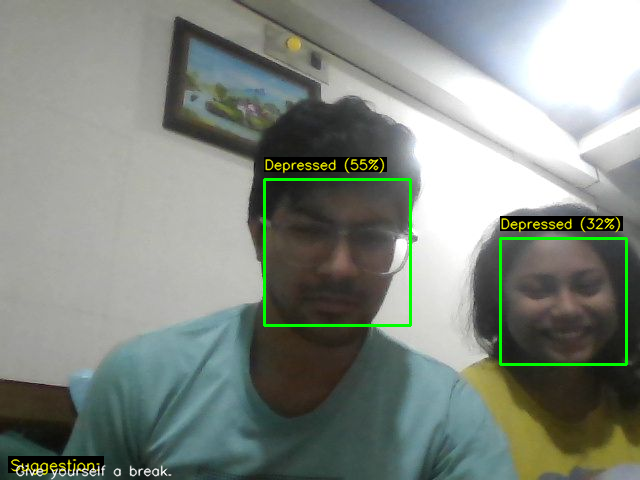


✅ --- Cycle Complete (Multiple Faces Processed) ---

--- Script Execution Finished ---


In [ ]:
# Step 11: Main Execution Block (Ensure Step 1.7 and face_cascade load ran)
# ==============================================================================
print("\n--- Step 11: Running Main Block (Multiple Faces) ---")
if __name__ == "__main__":
     print("Main block starting...")
     # Check all dependencies
     model_ready = 'model' in globals() and model is not None and model_built_flag
     bonn_ready = 'bonn_data_present' in globals() and bonn_data_present
     cascade_ready = 'face_cascade' in globals() and face_cascade is not None and not face_cascade.empty()

     if model_ready and bonn_ready and cascade_ready:
          print("Model, Face Cascade, and Bonn data appear ready.")
          # Load weights if needed
          training_occurred = 'history' in globals() and history is not None and hasattr(history, 'history') and history.history
          if not training_occurred and os.path.exists(MODEL_WEIGHTS_FILE):
              try: model.load_weights(MODEL_WEIGHTS_FILE); print(f" Weights loaded from {MODEL_WEIGHTS_FILE}.")
              except Exception as e: print(f" ERR loading weights: {e}")
          elif not training_occurred: print(f" WARN: Weights file '{MODEL_WEIGHTS_FILE}' not found.")

          print("\nRunning prediction cycle...")
          try:
              # Call the updated multi-face function
              run_live_prediction_colab_visual(model, COLAB_BONN_PATH, face_cascade)
          except Exception as main_e: print(f"\nLive run error: {main_e}"); traceback.print_exc()

     elif not model_ready: print("\nERROR: Model not ready.")
     elif not cascade_ready: print("\nERROR: Face Cascade classifier not loaded.")
     elif not bonn_ready: print("\nERROR: Bonn EEG data not found/verified.")
     else: print("\nERROR: Unknown state preventing prediction.")

     print("\n--- Script Execution Finished ---")